# Runtime  Prediction via QC

## About

This notebook is designed to 1) create a dataframe that brings together runtime information with the [information](https://docs.google.com/spreadsheets/d/1zSs_hRQrCIBlUmPpDvyEwpJv3X4t8Y73s6ZRdkBkeI8/edit#gid=983410225) provided by the QC group.  It then 2) calculates the correlation of QC variables to runtime for a core variant calling workflows.  Based on those correlations, it 3) generates a linear regression model to predict runtime from QC variables and then 4) evaluates the performance of this model on ~20% of the dataset that was excluded from the training.

In [329]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

# this allows plots to appear directly in the notebook
%matplotlib inline

In [330]:
import math
# read a dict for runtimes
f = open("sanger_timing.tsv", "r")
runtimes = {}
for line in iter(f):
    a = line.split("\t")
    runtimes[a[0]] = a[1]
f.close()

# read data into a DataFrame
data = pd.read_csv('PCAWG-QC_Summary-of-Measures_QC_Measures.tsv', delimiter='\t')
data['runtime'] = 0.0
# loop over and annotate with runtime
for index, row in data.iterrows():
    key = row['Project_code'] + "::" + row['Submitter_donor_ID']
    try:
        curr_runtime = math.log(float(runtimes[key]))
        #curr_runtime = float(runtimes[key])
        data.set_value(index, 'runtime', curr_runtime)
    except:
        continue
        
data.head()

,Project_code,Submitter_donor_ID,Normal_WGS_aliquot_ID,Tumour_WGS_aliquot_ID,Stars,Mean_Coverage_Normal,Mean_Coverage_Tumour,Median/Mean_Coverage_Normal,FWHM_Normal,Median/Mean_Coverage_Tumour,FWHM_Tumour,Somatic_Mutation_Calling_Coverage,%_of_paired_reads_mapping_to_different_chromosomes_Normal,%_of_paired_reads_mapping_to_different_chromosomes_Tumour,Ratio_of_difference_in_edits_between_paired_reads_Normal,Ratio_of_difference_in_edits_between_paired_reads_Tumour,runtime
0,BLCA-US,096b4f32-10c1-4737-a0dd-cae04c54ee33,e0fccaf5-925a-41f9-b87c-cd5ee4aecb59,301d6ce3-4099-4c1d-8e50-c04b7ce91450,5.0,37.98,45.40,1.026162,0.088868,1.038914,0.152645,2.802268e+09,2.14,2.32,1.177728,1.200458,4.179052
1,BLCA-US,178b28cd-99c3-48dc-8d09-1ef71b4cee80,c1da8eed-4919-4ba5-a735-3fba476c18a7,4838b5a9-968c-4178-bffb-3fafe1f6dc09,5.0,31.50,33.65,1.015003,0.114352,0.981037,0.097032,2.746502e+09,2.41,1.80,1.219270,1.093826,4.176824
2,BLCA-US,1e308b12-0590-4dae-94d0-a539fcf25df7,d6e91f4c-38c0-4393-9cb7-be076663dff3,c66c92d5-df65-46e6-861d-d8a98808e6a3,5.0,32.72,30.71,1.021017,0.095867,0.968090,0.085069,2.733112e+09,1.97,2.03,1.178552,1.159640,4.164207
3,BLCA-US,24f21425-b001-4986-aedf-5b4dd851c6ad,f88b2f4c-15f1-4808-bcec-89abc7466de6,973d0577-8ca4-44a1-817f-1d3c1bada151,4.5,37.60,39.17,1.012372,0.093099,0.893826,0.070527,2.773264e+09,2.93,2.12,1.188315,1.198255,4.023495
4,BLCA-US,3ed614e7-f356-4d87-985b-d3bbbae3bb40,c14e29aa-a979-4452-8019-7eebfb3d5d04,91f458e6-64b7-454d-a542-b0aa23638fd8,5.0,31.90,33.55,1.011833,0.083130,0.931186,0.081127,2.633835e+09,2.05,1.95,1.003750,1.063998,3.924358


In [331]:
# now I have a merged dataframe that has all QC values along with the runtime for the workflow
print(data.shape)

(2961, 17)


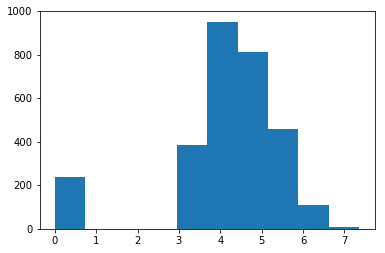

In [332]:
# Import matplotlib
import matplotlib.pyplot as plt

# Make a histogram of all the ratings in the average_rating column.
plt.hist(data["runtime"])

# Show the plot.
plt.show()

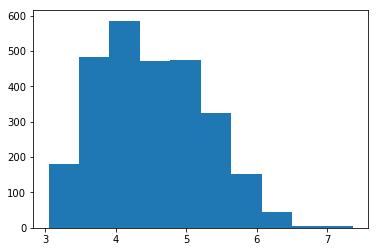

In [333]:
# remove 0 runtimes
data = data[data["runtime"] > 0.0]
plt.hist(data["runtime"])
plt.show()

In [334]:
# remove any NAN
data = data.dropna() 
data.isnull().values.any()

False

In [335]:
# showing zeros and nan have been removed
print(data.shape)

(2721, 17)


In [336]:
# general stats
data.describe()

,Stars,Mean_Coverage_Normal,Mean_Coverage_Tumour,Median/Mean_Coverage_Normal,FWHM_Normal,Median/Mean_Coverage_Tumour,FWHM_Tumour,Somatic_Mutation_Calling_Coverage,%_of_paired_reads_mapping_to_different_chromosomes_Normal,%_of_paired_reads_mapping_to_different_chromosomes_Tumour,Ratio_of_difference_in_edits_between_paired_reads_Normal,Ratio_of_difference_in_edits_between_paired_reads_Tumour,runtime
count,2721.000000,2721.000000,2721.000000,2721.000000,2721.000000,2721.000000,2721.000000,2.721000e+03,2721.000000,2721.000000,2721.000000,2721.000000,2721.000000
mean,4.633591,39.458754,52.510945,1.021147,0.107202,1.001676,0.114968,2.767964e+09,1.907677,1.882194,1.393810,1.388843,4.513328
std,0.618701,9.962816,16.240426,0.025867,0.060247,0.040909,0.068289,1.060536e+08,2.177744,1.654763,0.364620,0.324422,0.742826
min,1.000000,19.410000,7.450000,0.560367,0.046188,0.767974,0.046799,1.546442e+08,0.290000,0.300000,1.000506,1.000963,3.047666
25%,4.500000,33.600000,38.600000,1.013513,0.076415,0.984346,0.077441,2.755920e+09,0.980000,1.010000,1.191563,1.188612,3.922061
50%,5.000000,37.390000,51.460000,1.024989,0.089827,1.011688,0.095302,2.800633e+09,1.400000,1.430000,1.300403,1.312105,4.440993
75%,5.000000,42.620000,64.010000,1.030981,0.116184,1.028074,0.128667,2.817523e+09,2.130000,2.130000,1.479354,1.486944,5.071323
max,5.000000,177.890000,218.520000,1.106314,0.770586,1.131986,1.176241,2.846089e+09,57.900000,30.330000,5.083394,5.220612,7.362016


In [337]:
# look at correlation
data.corr()["runtime"]

Stars                                                       -0.107973
Mean_Coverage_Normal                                         0.179775
Mean_Coverage_Tumour                                         0.164330
Median/Mean_Coverage_Normal                                  0.020396
FWHM_Normal                                                 -0.009230
Median/Mean_Coverage_Tumour                                 -0.019306
FWHM_Tumour                                                  0.065747
Somatic_Mutation_Calling_Coverage                            0.008306
%_of_paired_reads_mapping_to_different_chromosomes_Normal    0.078384
%_of_paired_reads_mapping_to_different_chromosomes_Tumour    0.149728
Ratio_of_difference_in_edits_between_paired_reads_Normal     0.039422
Ratio_of_difference_in_edits_between_paired_reads_Tumour     0.097569
runtime                                                      1.000000
Name: runtime, dtype: float64

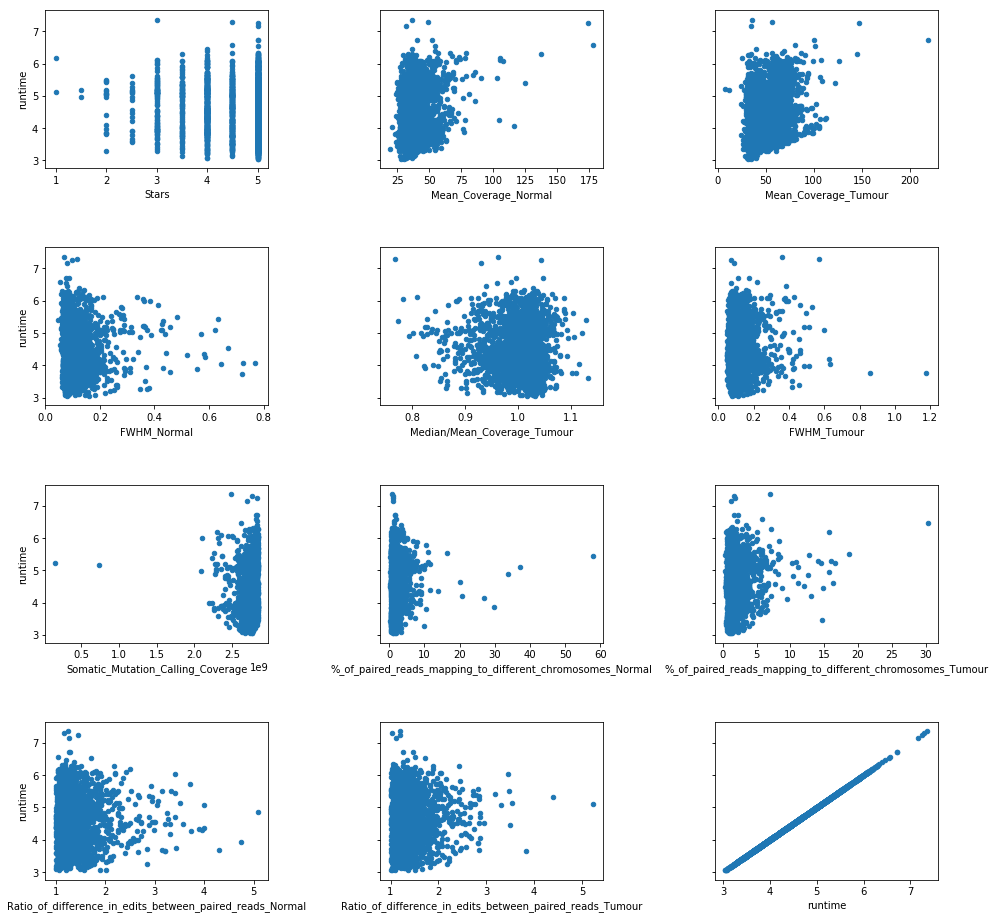

In [338]:
# visualize the relationship between the features and the response using scatterplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 3, sharey=True)
fig.subplots_adjust(hspace=.5, wspace=.5)
data.plot(kind='scatter', x='Stars', y='runtime', ax=axs[0, 0], figsize=(16, 16))
data.plot(kind='scatter', x='Mean_Coverage_Normal', y='runtime', ax=axs[0, 1])
data.plot(kind='scatter', x='Mean_Coverage_Tumour', y='runtime', ax=axs[0, 2])
data.plot(kind='scatter', x='FWHM_Normal', y='runtime', ax=axs[1, 0])
data.plot(kind='scatter', x='Median/Mean_Coverage_Tumour', y='runtime', ax=axs[1, 1])
data.plot(kind='scatter', x='FWHM_Tumour', y='runtime', ax=axs[1, 2])
data.plot(kind='scatter', x='Somatic_Mutation_Calling_Coverage', y='runtime', ax=axs[2, 0])
data.plot(kind='scatter', x='%_of_paired_reads_mapping_to_different_chromosomes_Normal', y='runtime', ax=axs[2, 1])
data.plot(kind='scatter', x='%_of_paired_reads_mapping_to_different_chromosomes_Tumour', y='runtime', ax=axs[2, 2])
data.plot(kind='scatter', x='Ratio_of_difference_in_edits_between_paired_reads_Normal', y='runtime', ax=axs[3, 0])
data.plot(kind='scatter', x='Ratio_of_difference_in_edits_between_paired_reads_Tumour', y='runtime', ax=axs[3, 1])
data.plot(kind='scatter', x='runtime', y='runtime', ax=axs[3, 2])


In [339]:
# now clear out the columns that we don't want to use
# Get all the columns from the dataframe.
columns = data.columns.tolist()
# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["runtime", "Project_code", "Submitter_donor_ID", "Normal_WGS_aliquot_ID", "Tumour_WGS_aliquot_ID"]]
#columns = [c for c in columns if c not in ["runtime", "Project_code", "Submitter_donor_ID", "Normal_WGS_aliquot_ID", "Tumour_WGS_aliquot_ID", "Median/Mean_Coverage_Normal", "FWHM_Normal", "Median/Mean_Coverage_Tumour", "FWHM_Tumour", "Somatic_Mutation_Calling_Coverage", "%_of_paired_reads_mapping_to_different_chromosomes_Normal", "Ratio_of_difference_in_edits_between_paired_reads_Normal", "Ratio_of_difference_in_edits_between_paired_reads_Tumour"]]

# Store the variable we'll be predicting on.
target = "runtime"

In [340]:
# Import a convenience function to split the sets.
from sklearn.model_selection import train_test_split

# Generate the training set.  Set random_state to be able to replicate results.
train = data.sample(frac=0.8, random_state=1)
# Select anything not in the training set and put it in the testing set.
test = data.loc[~data.index.isin(train.index)]
# Print the shapes of both sets.
print(train.shape)
print(test.shape)

(2177, 17)
(544, 17)


In [341]:
# Import the linearregression model.
from sklearn.linear_model import LinearRegression

# Initialize the model class.
model = LinearRegression()
train.head()
# Fit the model to the training data.
model.fit(train[columns], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [342]:
# now test 
# Import the scikit-learn function to compute error.
from sklearn.metrics import mean_squared_error

# Generate our predictions for the test set.
predictions = model.predict(test[columns])

# Compute error between our test predictions and the actual values.
mean_squared_error(predictions, test[target])

0.49942357957226485

In [343]:
# try random forest
# Import the random forest model.
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with some parameters.
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=1)
# Fit the model to the data.
model.fit(train[columns], train[target])
# Make predictions.
predictions = model.predict(test[columns])
# Compute the error.
mean_squared_error(predictions, test[target])

0.45859401928582127

                            OLS Regression Results                            
Dep. Variable:      predicted_runtime   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     2844.
Date:                Sun, 05 Feb 2017   Prob (F-statistic):               0.00
Time:                        22:46:27   Log-Likelihood:                 219.17
No. Observations:                2721   AIC:                            -434.3
Df Residuals:                    2719   BIC:                            -422.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.1287      0.026    118.659      0.0

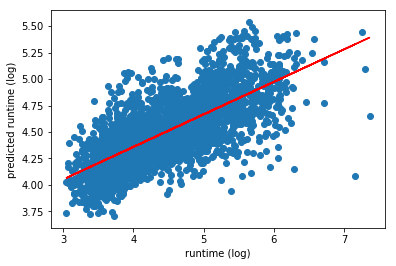

In [347]:
# look at predicted vs. actual
import statsmodels.api as sm
import numpy as np


data['predicted_runtime'] = model.predict(data[columns])
#data.plot(kind='scatter', x='runtime', y='predicted_runtime')

results = sm.OLS(data['predicted_runtime'],sm.add_constant(data['runtime'])).fit()

print(results.summary())

plt.scatter(data['runtime'],data['predicted_runtime'])

#X_plot = np.linspace(0,1,100)
#plt.plot(X_plot, X_plot*results.params[0] + results.params[1])

# fit with np.polyfit
m, b = np.polyfit(data['runtime'], data['predicted_runtime'], 1)

#plt.plot(x, y, '.')
plt.plot(data['runtime'], m*data['runtime'] + b, '-', color='r')
plt.ylabel('predicted runtime (log)')
plt.xlabel('runtime (log)')

plt.show()


## Summary
Seems like the coverage dominates the runtime.  The model agrees with actual runtime not particularly well, R^2 of 0.511, lower than the other two workflows.  It's possible that the number of sites we ran in contributed to the noise.  Sanger was the earliest variant pipeline and we executed it on the largest number of clouds, some of which had infrastructure issues.